In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_root = "/home/jturner/false_low_clouds_2023/Model/Model_flc_v2_data/"

In [3]:
time="00z"

date="20230907"

Import the GFS and SST data

In [4]:
gfs_file = data_root+"time_"+time+"/"+date+"/gfs.t"+time+".pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib", backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/home/jturner/miniconda3/lib/python3.9/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jturner/miniconda3/lib/python3.9/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  

In [5]:
sst_file = data_root+"time_"+time+"/"+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Filter the datasets to the region of interest

In [6]:
#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [7]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))
gfs_ds = gfs_ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon+360,max_lon+360))

For atmospheric tempurature, use from the level of most humidity

In [8]:
gfs_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 23, longitude: 31)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 42.5 42.25 42.0 41.75 ... 37.5 37.25 37.0
  * longitude      (longitude) float64 288.5 288.8 289.0 ... 295.5 295.8 296.0
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-09-22T20:14 GRIB to CDM+CF via cfgrib-0.9.1...

Identify the indices where the maximum humidity occurs for each height level

In [9]:
max_humidity_indices = gfs_ds['q'].argmax(dim='isobaricInhPa')

Use these indices to filter the temperature data

In [10]:
T_maxq = gfs_ds['t'].isel(isobaricInhPa=max_humidity_indices)

In [11]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = gfs_ds.t[0][0:begin,0:end]

T_diff = T_maxq[0:begin,0:end].values - sst_ds.sst[:,:].values

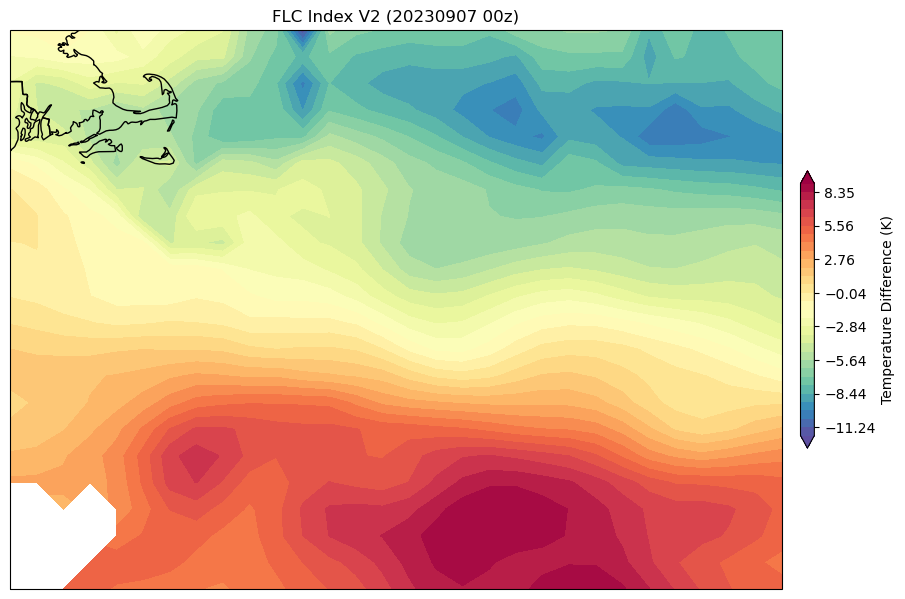

In [14]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(np.nanmin(T_diff), np.nanmax(T_diff), 31)

c=ax.contourf(dims.longitude, dims.latitude, T_diff, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index V2 ('+date+' '+ time+')')
clb.set_label('Temperature Difference (K)')

ax.add_feature(cfeature.STATES)